# Chapter 2: financial data

In [1]:
# Core data handling
import yfinance as yf
import pandas as pd
import numpy as np

# Book data (pip install "git+https://github.com/dppalomar/pob.git#subdirectory=python")
from pob_python import SP500_stocks_2015to2020, cryptos_2017to2021_daily

# Statistical analysis
from scipy.stats import norm, skew, kurtosis
import arch

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Prices

In [2]:
# S&P 500 data
sp500 = yf.download('^GSPC', start='2007-01-01', end='2022-11-04')
sp500_prices = sp500['Close']

# Bitcoin data 
btc = yf.download('BTC-USD', start='2017-01-01', end='2022-11-04')
btc_prices = btc['Close']

C:\Users\Luigi\AppData\Local\Temp\ipykernel_10264\2400062104.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2007-01-01', end='2022-11-04')
[*********************100%***********************]  1 of 1 completed
C:\Users\Luigi\AppData\Local\Temp\ipykernel_10264\2400062104.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start='2017-01-01', end='2022-11-04')
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

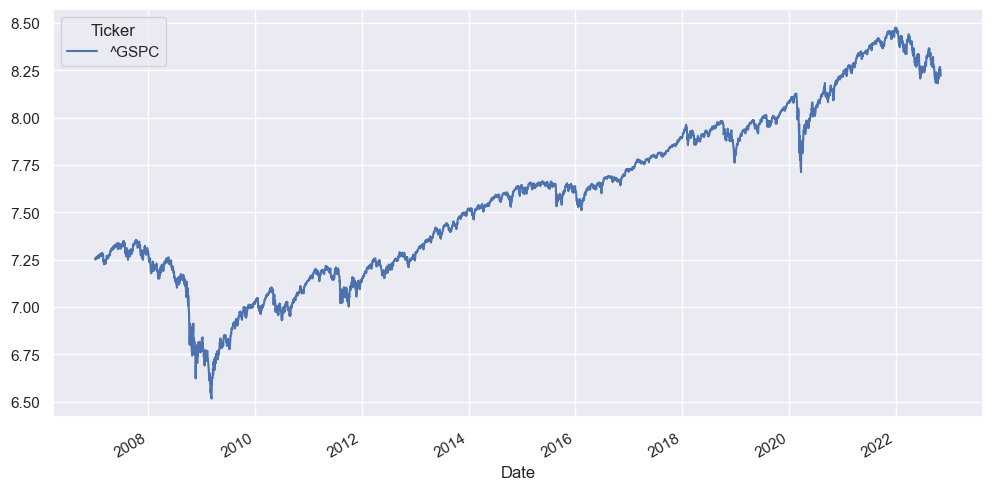

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))
np.log(sp500_prices).plot(ax=ax)

<Axes: xlabel='Date'>

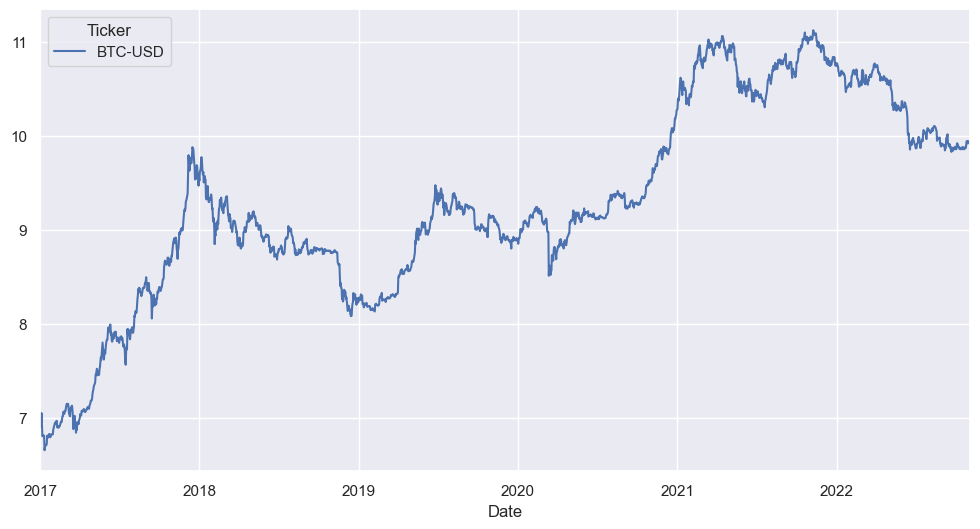

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
np.log(btc_prices).plot(ax=ax)

## Returns

In [5]:
# S&P 500 returns
sp500_returns = np.log(sp500_prices).diff().dropna()

# Bitcoin returns
btc_returns = np.log(btc_prices).diff().dropna()

In [6]:
def plot_returns(returns, title):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(returns, linewidth=0.5)
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    plt.show()

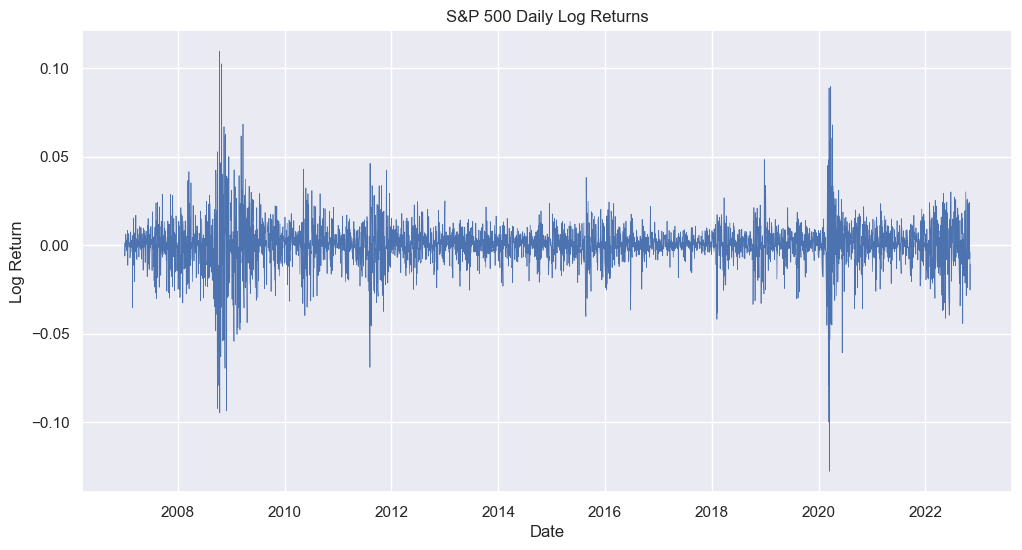

In [7]:
plot_returns(sp500_returns, 'S&P 500 Daily Log Returns')

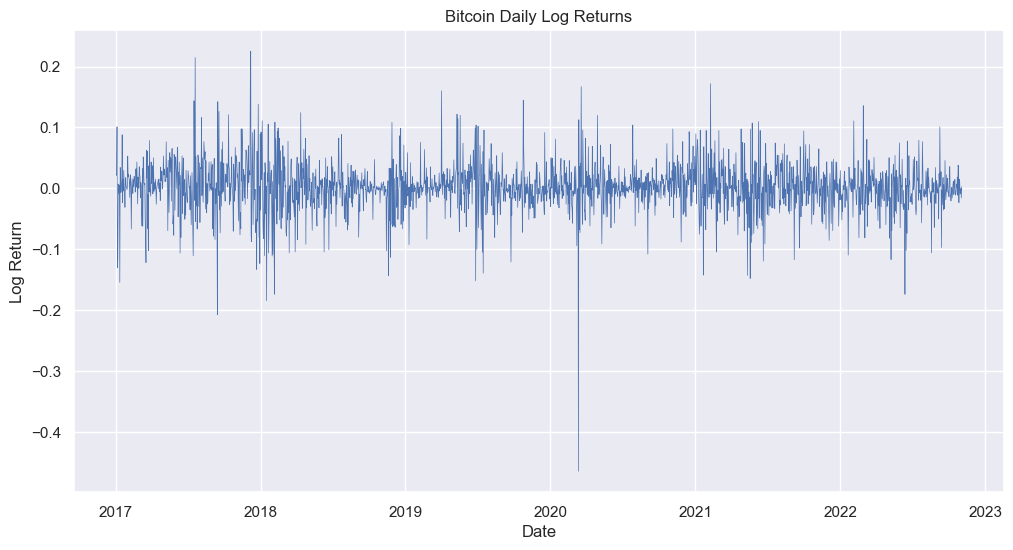

In [8]:
plot_returns(btc_returns, 'Bitcoin Daily Log Returns')

## Non-Gaussianity

In [9]:
def analyze_distribution(returns, asset_name):
    print(f"{asset_name} Distribution Properties:")
    print(f"Skewness: {skew(returns).item():.4f}")  # Fixed line
    print(f"Excess Kurtosis: {kurtosis(returns, fisher=False).item():.4f}") 
    
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    
    # Histogram with normal fit
    sns.histplot(returns, kde=False, ax=ax[0], stat='density')
    x = np.linspace(returns.min(), returns.max(), 100)
    ax[0].plot(x, norm.pdf(x, returns.mean(), 0.6*returns.std()))
    ax[0].set_title('Return Distribution')
    
    # Q-Q Plot
    sm.graphics.qqplot(returns.squeeze(), line='45', fit=True, ax=ax[1])
    ax[1].set_xlim(-4, 4)
    ax[1].set_title('Q-Q Plot')
    
    plt.tight_layout()
    plt.show()

S&P 500 Distribution Properties:
Skewness: -0.5376
Excess Kurtosis: 14.9277


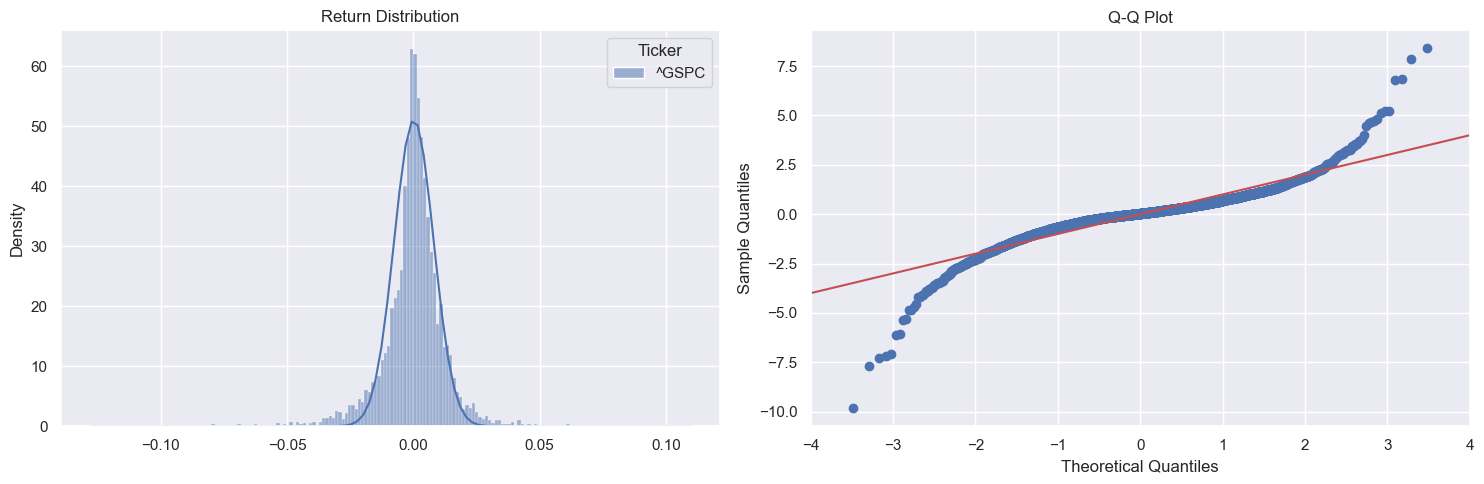

In [10]:
analyze_distribution(sp500_returns, 'S&P 500')

Bitcoin Distribution Properties:
Skewness: -0.7073
Excess Kurtosis: 13.3596


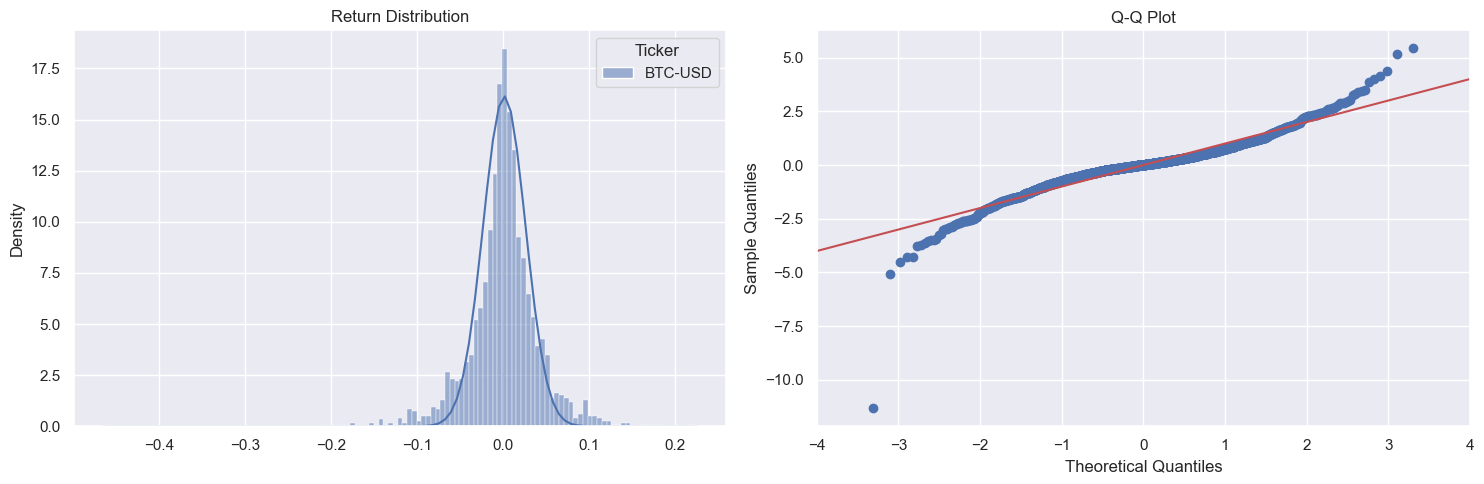

In [11]:
analyze_distribution(btc_returns, 'Bitcoin')

## Autocorrelation

In [12]:
def plot_autocorrelation(returns, title):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
    plot_acf(returns, ax=ax1, lags=40)
    plot_pacf(returns, ax=ax2, lags=40)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

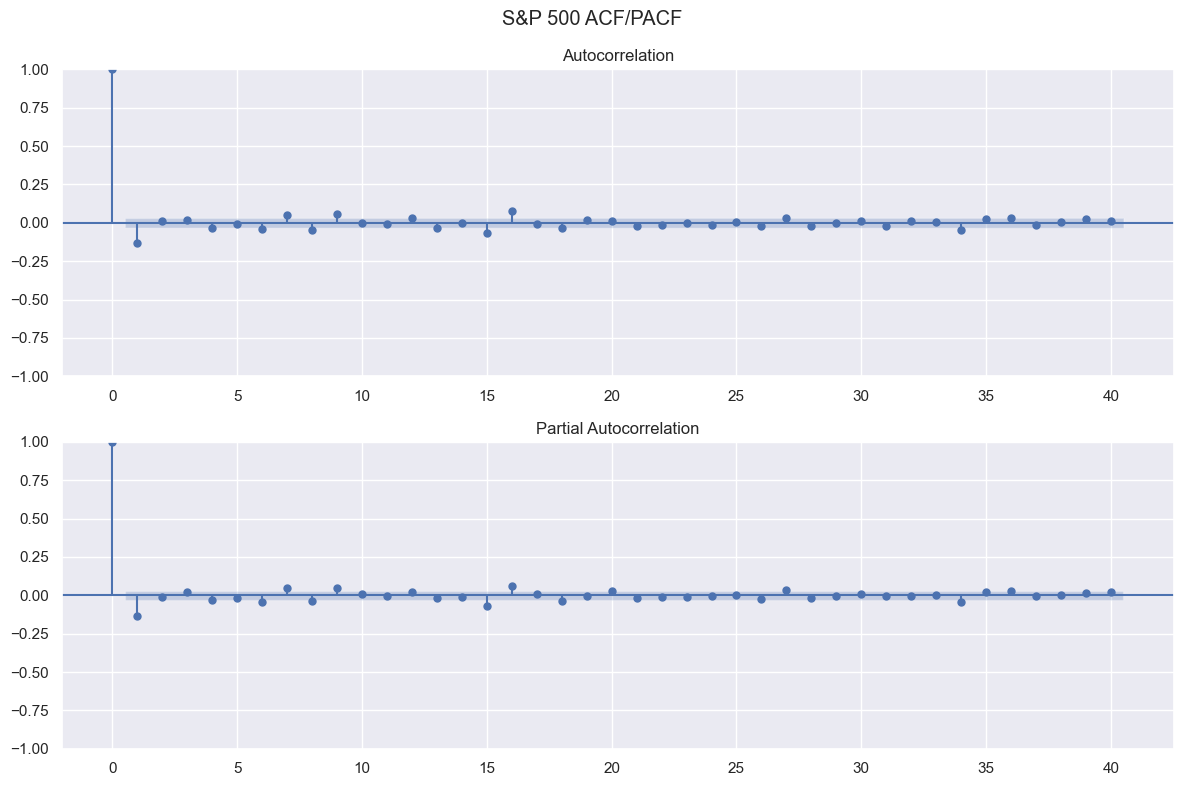

In [13]:
plot_autocorrelation(sp500_returns, 'S&P 500 ACF/PACF')

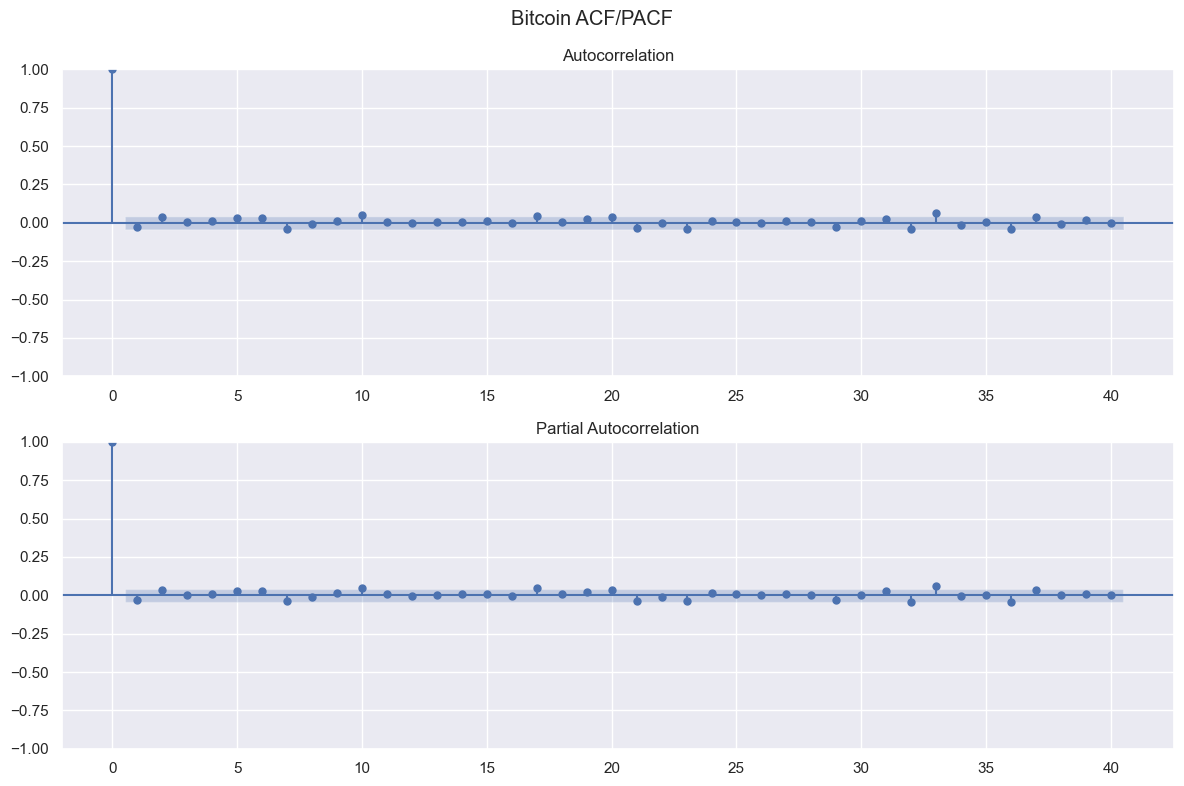

In [14]:
plot_autocorrelation(btc_returns, 'Bitcoin ACF/PACF')

## Volatility

In [15]:
def estimate_volatility(returns):
    model = arch.arch_model(returns, vol='Garch', p=1, q=1, rescale=False)
    result = model.fit(disp='off')
    return result.conditional_volatility

sp500_vol = estimate_volatility(sp500_returns)
btc_vol = estimate_volatility(btc_returns)

def plot_volatility(returns, vol, title):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(returns, alpha=0.5, label='Returns')
    ax.plot(vol, color='red', label='Conditional Volatility')
    ax.set_title(title)
    ax.legend()
    plt.show()

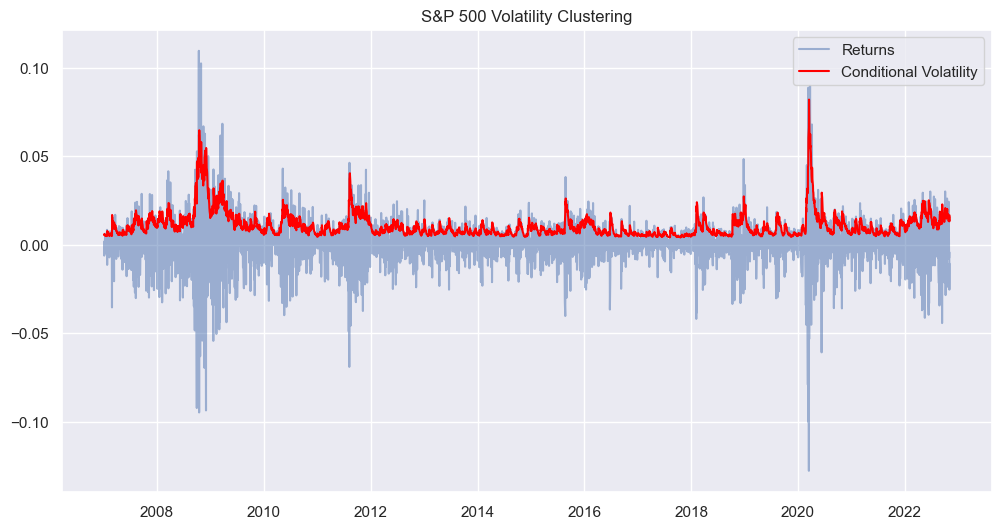

In [16]:
plot_volatility(sp500_returns, sp500_vol, 'S&P 500 Volatility Clustering')

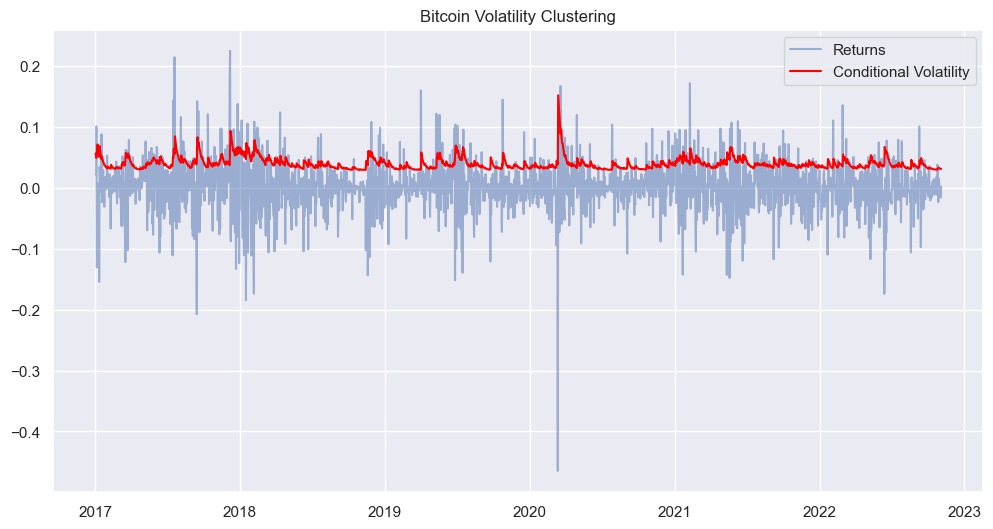

In [17]:
plot_volatility(btc_returns, btc_vol, 'Bitcoin Volatility Clustering')

## Autocorrelation of returns

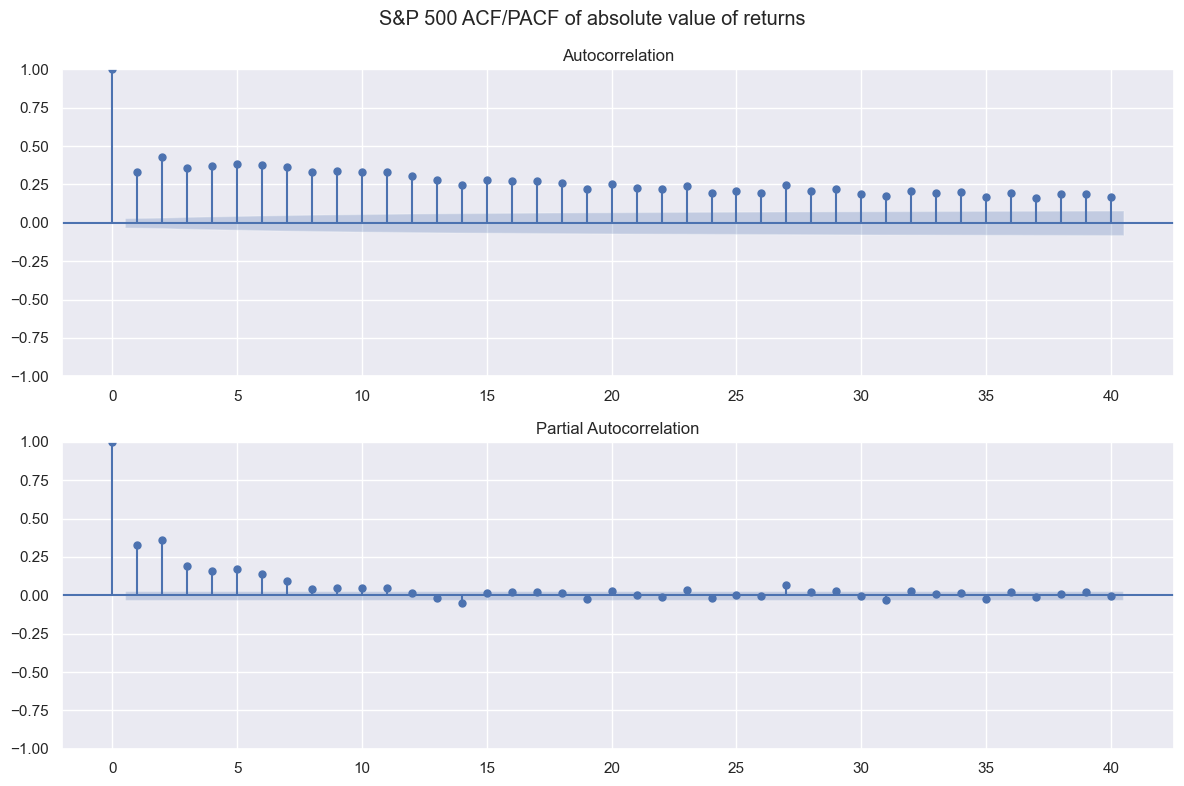

In [18]:
plot_autocorrelation(abs(sp500_returns), 'S&P 500 ACF/PACF of absolute value of returns')

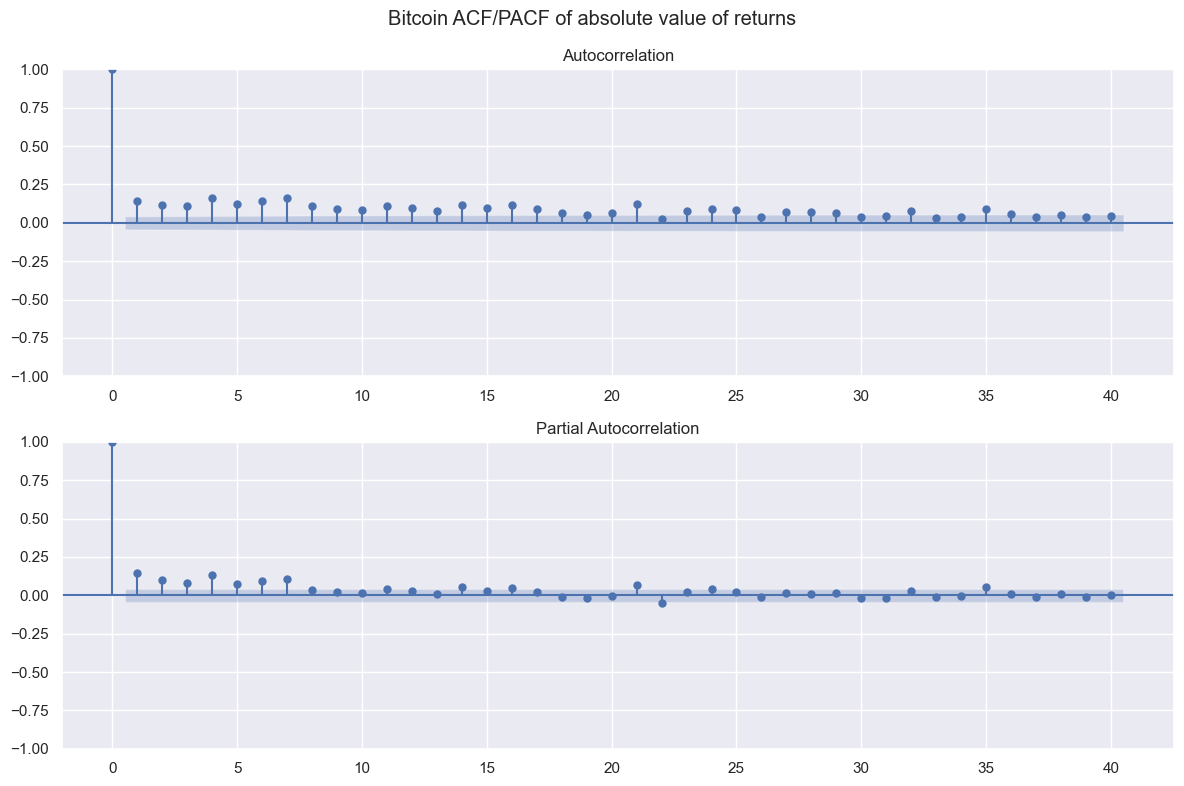

In [19]:
plot_autocorrelation(abs(btc_returns), 'Bitcoin ACF/PACF of absolute value of returns')

## Asset structure

In [20]:
from pob_python import SP500_stocks_2015to2020, cryptos_2017to2021_hourly

In [21]:
def plot_correlation_matrix(prices, title):
    returns = np.log(prices).diff().dropna()
    corr_matrix = returns.corr()
    
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=False, cmap='viridis',
                xticklabels=True, yticklabels=True)
    plt.title(title)
    plt.show()

In [22]:
data = SP500_stocks_2015to2020.sample(n=40, axis='columns')[-200:]
data.head()

,DXCM,UDR,HLT,EXPE,GRMN,CDNS,EA,CTSH,AEP,VRSN,...,ECL,CMS,EIX,BRK.B,ATVI,WST,FTNT,AEE,SNA,CNC
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-06,224.76,46.5901,105.3084,107.182,93.9950,67.18,103.230,61.9988,90.1969,188.26,...,184.5981,60.2392,69.1443,222.61,54.8493,147.0937,103.59,73.3020,161.368,60.98
2019-12-09,221.00,46.5512,104.5895,108.397,94.4624,66.03,102.030,61.2270,89.6795,188.56,...,183.3999,60.0628,68.7955,221.38,54.0346,144.3607,103.85,73.0680,162.121,59.17
2019-12-10,215.53,46.4345,104.5396,111.436,94.1800,65.85,101.835,60.4552,89.7576,188.14,...,183.3504,60.2196,69.0571,221.26,55.5745,144.9891,103.55,73.2005,161.554,59.62
2019-12-11,212.36,45.5395,105.5380,111.546,95.0370,65.89,103.200,60.0397,89.9626,189.92,...,183.3108,60.2294,69.2993,222.57,56.1110,146.2958,104.14,73.5538,164.019,58.64
2019-12-12,202.00,45.1211,106.3568,113.080,95.2220,66.88,105.090,61.1182,88.9766,189.97,...,183.3801,59.5629,69.2218,225.92,58.1774,146.0364,104.40,73.3183,166.699,58.52


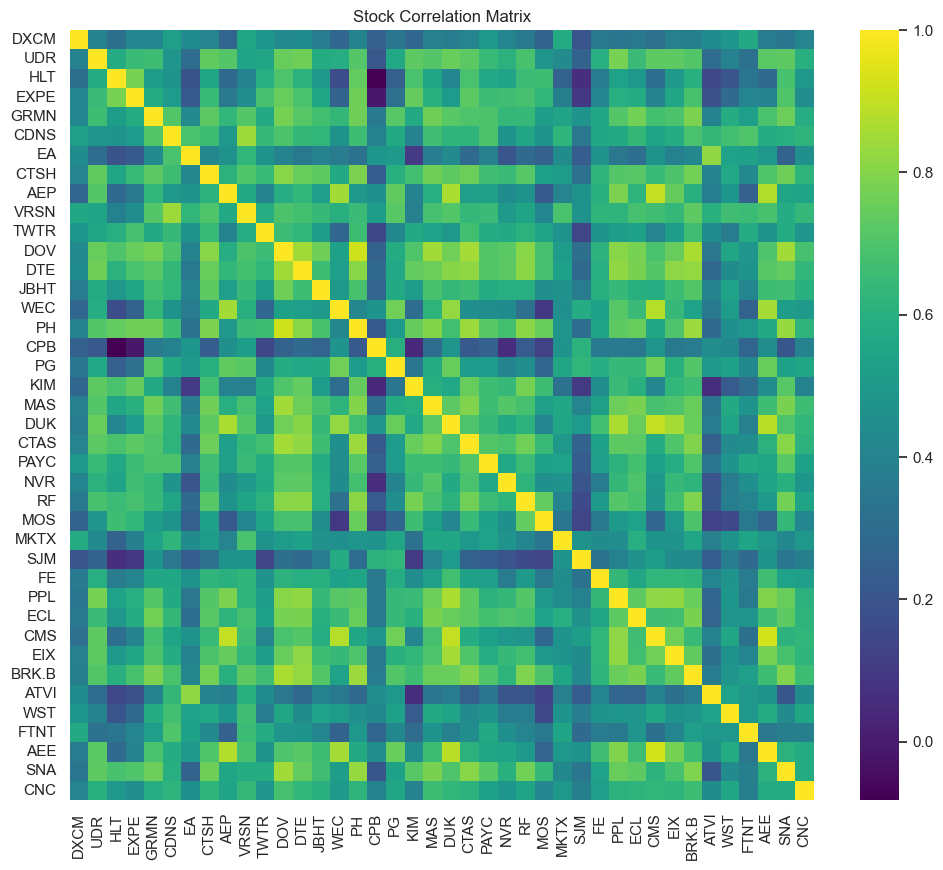

In [23]:
plot_correlation_matrix(data, 'Stock Correlation Matrix')

In [24]:
data = cryptos_2017to2021_hourly.sample(n=40, axis='columns')[-200:]
data.head()

,ETC,MKR,XTZ,BTC,DCR,UMA,AVAX,CRO,NEAR,SOL,...,DOGE,THETA,TRX,COMP,ANKR,BNT,IOST,VET,BAT,NANO
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-08 23:00:00,56.677712,3246.084096,3.446726,33379.10,129.477529,12.817574,14.817984,0.113823,2.899976,41.124720,...,0.326184,8.919563,0.072439,349.545935,0.090260,4.106631,0.028516,0.112821,0.671254,6.942853
2021-06-09 00:00:00,54.920689,3146.264849,3.305765,32886.64,127.633050,12.562696,14.312923,0.112143,2.835815,40.686364,...,0.316820,8.639978,0.071157,341.889509,0.088297,4.017761,0.027769,0.108809,0.652800,6.646390
2021-06-09 01:00:00,53.891224,3074.987063,3.266647,32523.37,126.320769,12.358881,14.104410,0.110579,2.809369,40.246044,...,0.313990,8.408592,0.070429,335.738749,0.086837,3.965900,0.027463,0.106257,0.643312,6.569721
2021-06-09 02:00:00,54.659135,3103.968352,3.268044,32867.79,128.118645,12.555496,14.036190,0.112079,2.816441,40.692296,...,0.318719,8.602487,0.070666,337.617939,0.088533,3.988506,0.027530,0.108102,0.647824,6.764191
2021-06-09 03:00:00,54.584064,3095.156344,3.287860,32862.17,127.702393,12.750522,13.900369,0.111731,2.872154,40.509526,...,0.318175,8.770585,0.070746,334.898374,0.088261,3.996697,0.027752,0.108192,0.646070,6.786038


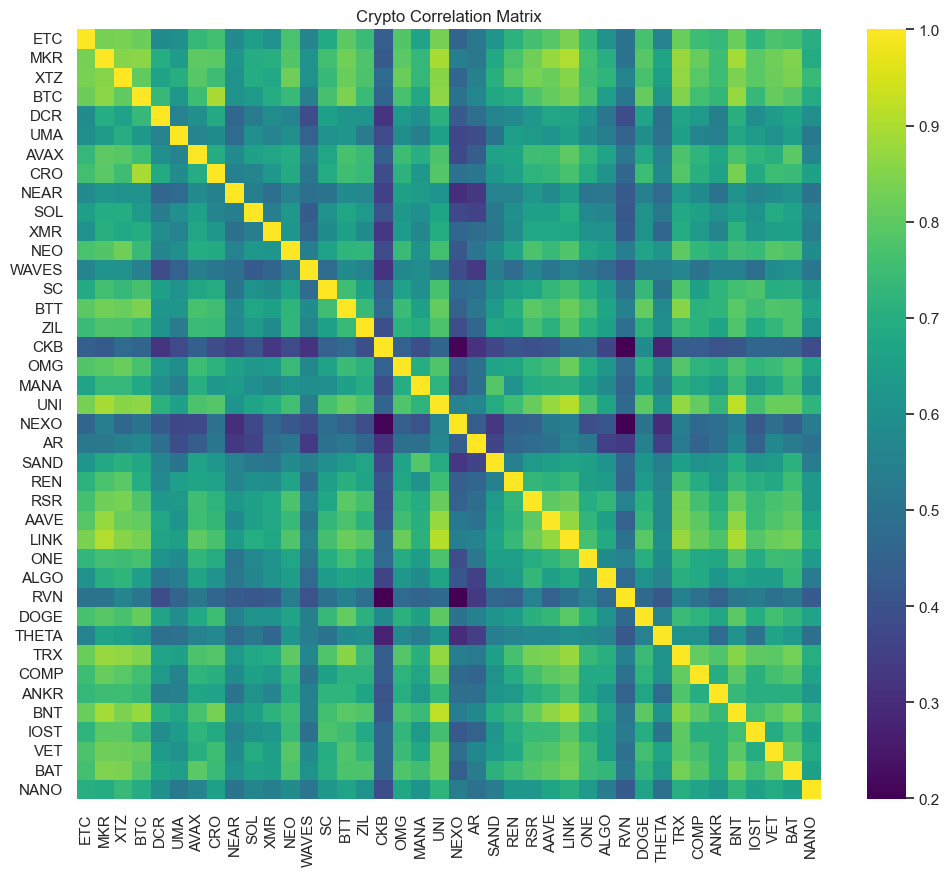

In [25]:
plot_correlation_matrix(data, 'Crypto Correlation Matrix')